In [28]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [29]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 8.93 s, sys: 2.04 s, total: 11 s
Wall time: 11.1 s


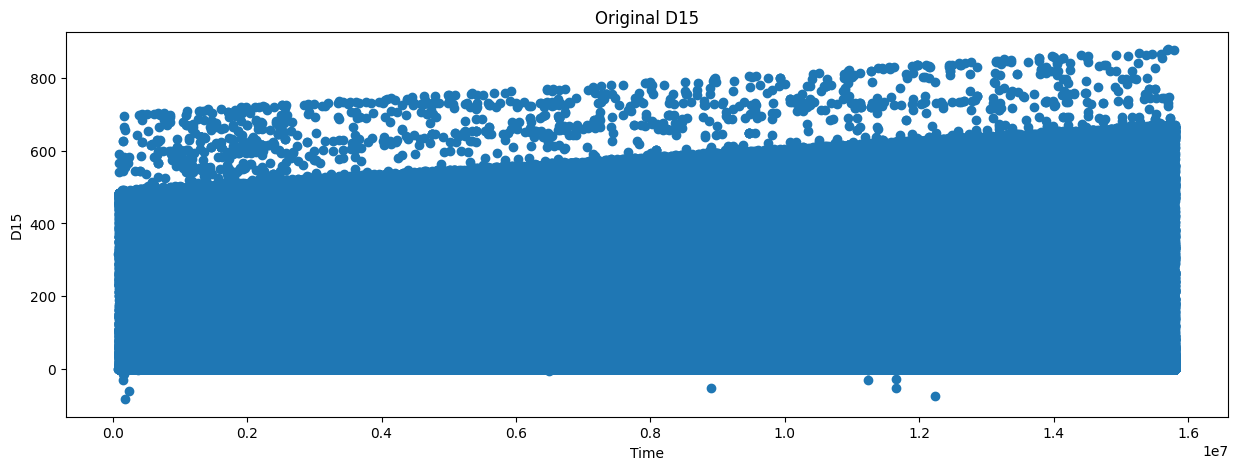

In [30]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

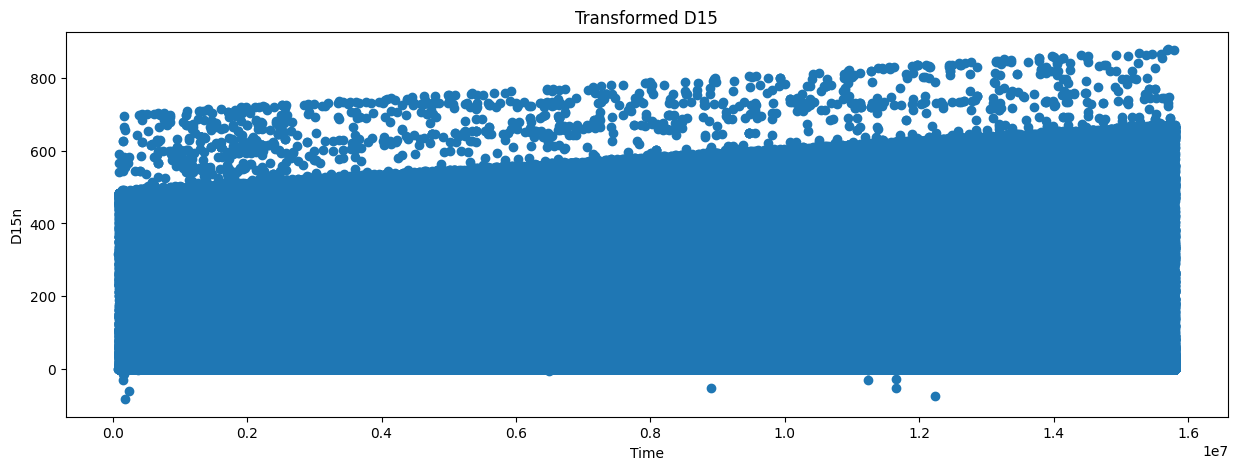

In [31]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [32]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i, f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if X_train[f].dtype == 'object': 
        df_comb = pd.concat([X_train[f], X_test[f]], axis=0)
        df_comb, _ = df_comb.factorize(sort=True)
        if df_comb.max() > 32000: 
            print(f, 'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # Convert Categorical to Ordered Categorical
    elif isinstance(X_train[f].dtype, pd.CategoricalDtype):
        X_train[f] = X_train[f].astype('category').cat.as_ordered()
        X_test[f] = X_test[f].astype('category').cat.as_ordered()
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(), X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1, inplace=True)
        X_test[f].fillna(-1, inplace=True)


<timed exec>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, t

CPU times: user 657 ms, sys: 0 ns, total: 657 ms
Wall time: 656 ms


In [33]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [34]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , 

<timed exec>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_65913/1299026.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
/tmp/ipykernel_65913/1299026.py:10: PerformanceWarning: DataFrame is high

card1_addr1 , 

/tmp/ipykernel_65913/1299026.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
/tmp/ipykernel_65913/1299026.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 

/tmp/ipykernel_65913/1299026.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
/tmp/ipykernel_65913/1299026.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)
/tmp/ipykernel_65913/1299026.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1

'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 

/tmp/ipykernel_65913/1299026.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_65913/1299026.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_65913/1299026.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will 

'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 

/tmp/ipykernel_65913/1299026.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_65913/1299026.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_65913/1299026.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will 

'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 

/tmp/ipykernel_65913/1299026.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_65913/1299026.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_65913/1299026.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will 

'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 2.4 s, sys: 85.7 ms, total: 2.49 s
Wall time: 2.5 s


/tmp/ipykernel_65913/1299026.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_65913/1299026.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_65913/1299026.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will 

In [35]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [36]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [37]:
# TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [38]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

if BUILD95:
    # Convert categorical columns to integers
    cat_cols = [col for col in X_train.columns if X_train[col].dtype.name == 'category']
    for col in cat_cols:
        X_train[col] = X_train[col].cat.codes.astype('int')
        X_test[col] = X_test[col].cat.codes.astype('int')

    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        # USE GPU
        tree_method='gpu_hist',
        enable_categorical=True  # Enable categorical support
    )
    
    h = clf.fit(X_train.loc[idxT, cols], y_train[idxT], 
                eval_set=[(X_train.loc[idxV, cols], y_train[idxV])],
                verbose=50)

    # Example of manually monitoring performance
    y_pred = clf.predict_proba(X_train.loc[idxV, cols])[:, 1]
    auc = roc_auc_score(y_train[idxV], y_pred)
    print(f"AUC on validation set: {auc}")



XGBoost version: 2.1.0
[0]	validation_0-logloss:0.20592


/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:48:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[50]	validation_0-logloss:0.12729
[100]	validation_0-logloss:0.10261
[150]	validation_0-logloss:0.09285
[200]	validation_0-logloss:0.08837
[250]	validation_0-logloss:0.08619
[300]	validation_0-logloss:0.08520
[350]	validation_0-logloss:0.08455
[400]	validation_0-logloss:0.08431
[450]	validation_0-logloss:0.08426
[500]	validation_0-logloss:0.08439
[550]	validation_0-logloss:0.08454
[600]	validation_0-logloss:0.08483
[650]	validation_0-logloss:0.08509
[700]	validation_0-logloss:0.08539
[750]	validation_0-logloss:0.08574
[800]	validation_0-logloss:0.08605
[850]	validation_0-logloss:0.08648
[900]	validation_0-logloss:0.08697
[950]	validation_0-logloss:0.08738
[1000]	validation_0-logloss:0.08788
[1050]	validation_0-logloss:0.08835
[1100]	validation_0-logloss:0.08885
[1150]	validation_0-logloss:0.08934
[1200]	validation_0-logloss:0.08982
[1250]	validation_0-logloss:0.09034
[1300]	validation_0-logloss:0.09091
[1350]	validation_0-logloss:0.09137
[1400]	validation_0-logloss:0.09185
[1450]	valid

/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:49:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


AUC on validation set: 0.927533101948816


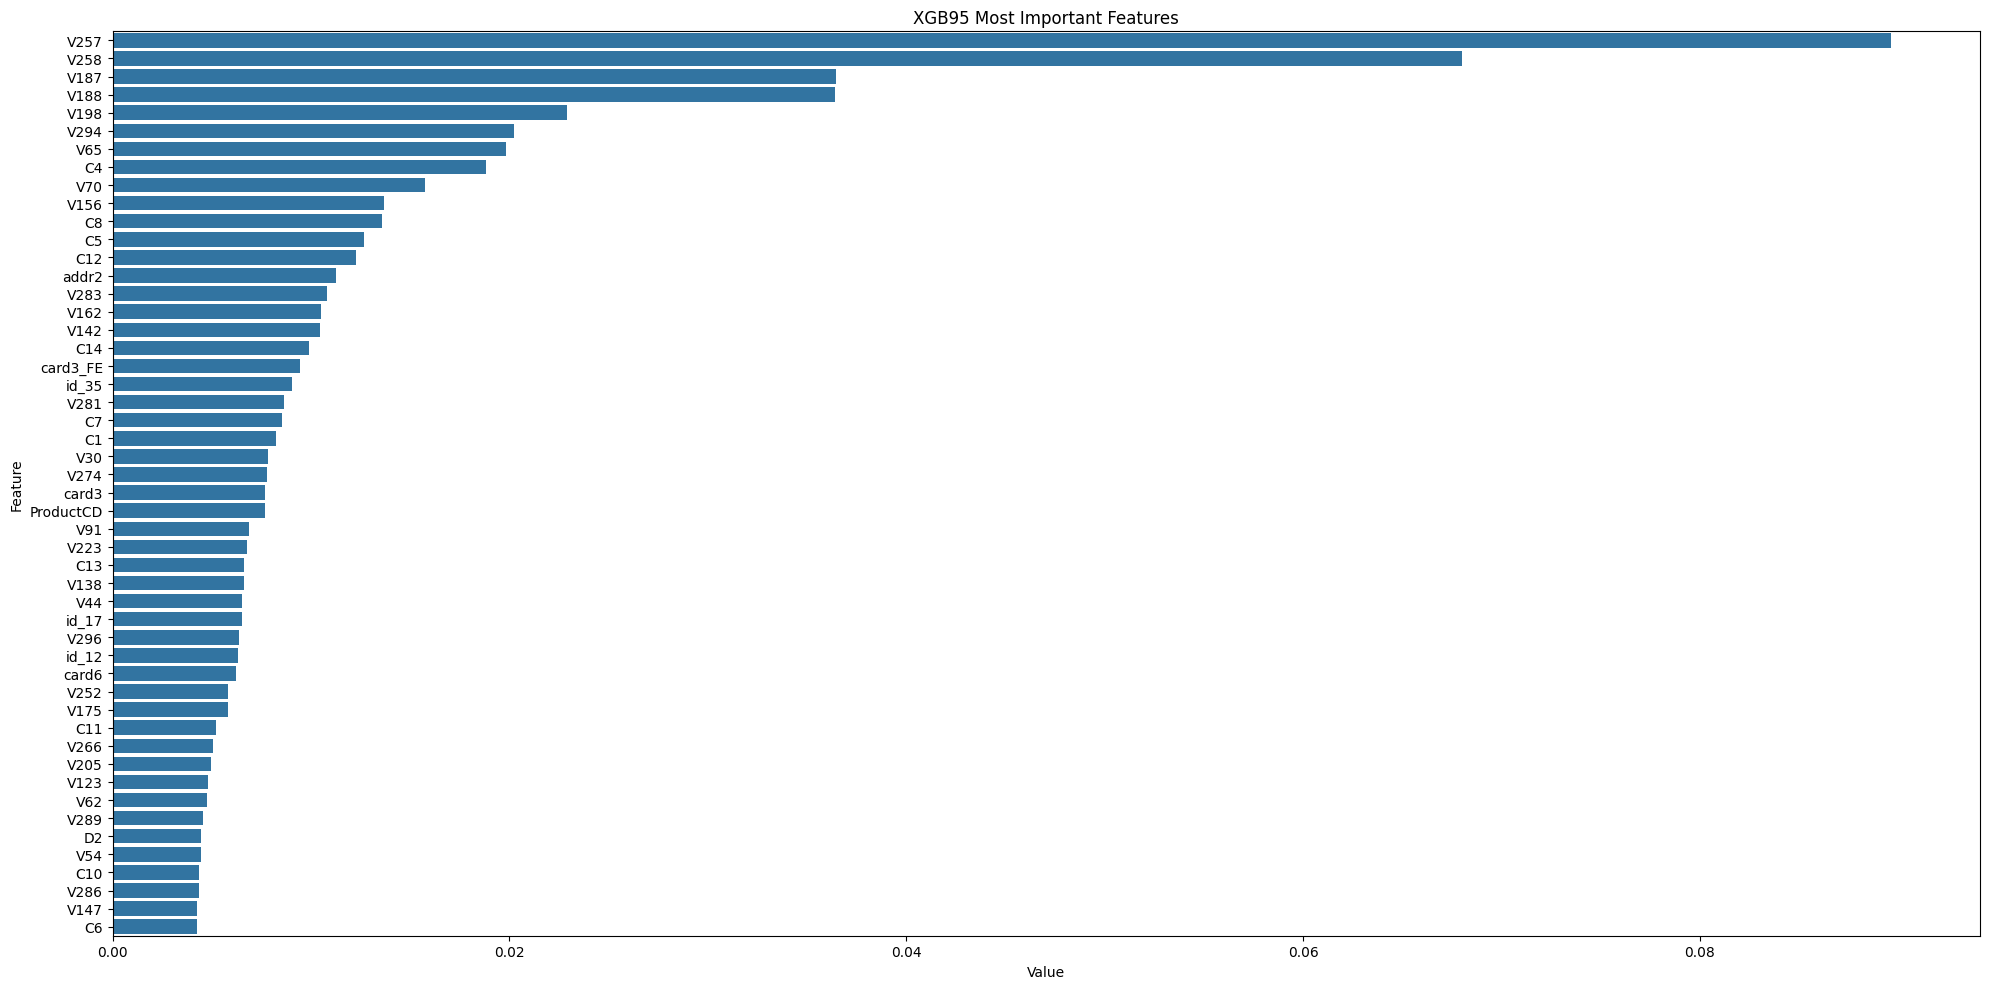

In [39]:
if BUILD95:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB95 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()

In [40]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

/tmp/ipykernel_65913/3600872321.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
/tmp/ipykernel_65913/3600872321.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))


In [42]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import gc

if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold', i, 'withholding month', month)
        print(' rows of train =', len(idxT), 'rows of holdout =', len(idxV))
        
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE GPU
            tree_method='gpu_hist' 
        )        
        clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV], y_train.iloc[idxV])],
                verbose=100)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:, 1]
        preds += clf.predict_proba(X_test[cols])[:, 1] / skf.n_splits
        del clf
        gc.collect()
        
    print('#'*20)
    print('XGB95 OOF CV =', roc_auc_score(y_train, oof))


Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.76670


/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:49:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.88579
[200]	validation_0-auc:0.90261
[300]	validation_0-auc:0.90969
[400]	validation_0-auc:0.91308
[500]	validation_0-auc:0.91390
[600]	validation_0-auc:0.91445
[700]	validation_0-auc:0.91399
[800]	validation_0-auc:0.91336
[900]	validation_0-auc:0.91273
[1000]	validation_0-auc:0.91243
[1100]	validation_0-auc:0.91214
[1200]	validation_0-auc:0.91135
[1300]	validation_0-auc:0.91119
[1400]	validation_0-auc:0.91118
[1500]	validation_0-auc:0.91116
[1600]	validation_0-auc:0.91138
[1700]	validation_0-auc:0.91154
[1800]	validation_0-auc:0.91167
[1900]	validation_0-auc:0.91156
[2000]	validation_0-auc:0.91152
[2100]	validation_0-auc:0.91143
[2200]	validation_0-auc:0.91144
[2300]	validation_0-auc:0.91128
[2400]	validation_0-auc:0.91100
[2500]	validation_0-auc:0.91113
[2600]	validation_0-auc:0.91125
[2700]	validation_0-auc:0.91136
[2800]	validation_0-auc:0.91145
[2900]	validation_0-auc:0.91140
[3000]	validation_0-auc:0.91123
[3100]	validation_0-auc:0.91144
[3200]	validation

/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.83318


/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.91353
[200]	validation_0-auc:0.93372
[300]	validation_0-auc:0.94137
[400]	validation_0-auc:0.94379
[500]	validation_0-auc:0.94439
[600]	validation_0-auc:0.94477
[700]	validation_0-auc:0.94459
[800]	validation_0-auc:0.94421
[900]	validation_0-auc:0.94382
[1000]	validation_0-auc:0.94333
[1100]	validation_0-auc:0.94292
[1200]	validation_0-auc:0.94253
[1300]	validation_0-auc:0.94217
[1400]	validation_0-auc:0.94188
[1500]	validation_0-auc:0.94166
[1600]	validation_0-auc:0.94158
[1700]	validation_0-auc:0.94141
[1800]	validation_0-auc:0.94132
[1900]	validation_0-auc:0.94117
[2000]	validation_0-auc:0.94113
[2100]	validation_0-auc:0.94103
[2200]	validation_0-auc:0.94099
[2300]	validation_0-auc:0.94096
[2400]	validation_0-auc:0.94085
[2500]	validation_0-auc:0.94078
[2600]	validation_0-auc:0.94089
[2700]	validation_0-auc:0.94084
[2800]	validation_0-auc:0.94080
[2900]	validation_0-auc:0.94083
[3000]	validation_0-auc:0.94081
[3100]	validation_0-auc:0.94071
[3200]	validation

/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 2 withholding month 13
 rows of train = 497955 rows of holdout = 92585
[0]	validation_0-auc:0.83990


/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.91126
[200]	validation_0-auc:0.93052
[300]	validation_0-auc:0.93836
[400]	validation_0-auc:0.94078
[500]	validation_0-auc:0.94148
[600]	validation_0-auc:0.94215
[700]	validation_0-auc:0.94187
[800]	validation_0-auc:0.94176
[900]	validation_0-auc:0.94175
[1000]	validation_0-auc:0.94169
[1100]	validation_0-auc:0.94120
[1200]	validation_0-auc:0.94084
[1300]	validation_0-auc:0.94076
[1400]	validation_0-auc:0.94067
[1500]	validation_0-auc:0.94039
[1600]	validation_0-auc:0.94008
[1700]	validation_0-auc:0.93982
[1800]	validation_0-auc:0.93970
[1900]	validation_0-auc:0.93978
[2000]	validation_0-auc:0.93978
[2100]	validation_0-auc:0.93960
[2200]	validation_0-auc:0.93960
[2300]	validation_0-auc:0.93973
[2400]	validation_0-auc:0.93996
[2500]	validation_0-auc:0.94008
[2600]	validation_0-auc:0.94018
[2700]	validation_0-auc:0.94036
[2800]	validation_0-auc:0.94032
[2900]	validation_0-auc:0.94029
[3000]	validation_0-auc:0.94034
[3100]	validation_0-auc:0.94012
[3200]	validation

/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 3 withholding month 17
 rows of train = 501214 rows of holdout = 89326
[0]	validation_0-auc:0.82379


/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.91077
[200]	validation_0-auc:0.93114
[300]	validation_0-auc:0.93917
[400]	validation_0-auc:0.94119
[500]	validation_0-auc:0.94177
[600]	validation_0-auc:0.94121
[700]	validation_0-auc:0.94106
[800]	validation_0-auc:0.94051
[900]	validation_0-auc:0.93975
[1000]	validation_0-auc:0.93940
[1100]	validation_0-auc:0.93894
[1200]	validation_0-auc:0.93853
[1300]	validation_0-auc:0.93852
[1400]	validation_0-auc:0.93814
[1500]	validation_0-auc:0.93789
[1600]	validation_0-auc:0.93757
[1700]	validation_0-auc:0.93751
[1800]	validation_0-auc:0.93743
[1900]	validation_0-auc:0.93740
[2000]	validation_0-auc:0.93734
[2100]	validation_0-auc:0.93733
[2200]	validation_0-auc:0.93729
[2300]	validation_0-auc:0.93732
[2400]	validation_0-auc:0.93732
[2500]	validation_0-auc:0.93729
[2600]	validation_0-auc:0.93709
[2700]	validation_0-auc:0.93703
[2800]	validation_0-auc:0.93696
[2900]	validation_0-auc:0.93686
[3000]	validation_0-auc:0.93691
[3100]	validation_0-auc:0.93687
[3200]	validation

/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:00:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 4 withholding month 14
 rows of train = 504519 rows of holdout = 86021
[0]	validation_0-auc:0.84720


/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:01:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.92877
[200]	validation_0-auc:0.94528
[300]	validation_0-auc:0.95061
[400]	validation_0-auc:0.95188
[500]	validation_0-auc:0.95190
[600]	validation_0-auc:0.95135
[700]	validation_0-auc:0.95122
[800]	validation_0-auc:0.95088
[900]	validation_0-auc:0.95061
[1000]	validation_0-auc:0.95050
[1100]	validation_0-auc:0.95033
[1200]	validation_0-auc:0.95008
[1300]	validation_0-auc:0.94980
[1400]	validation_0-auc:0.94950
[1500]	validation_0-auc:0.94929
[1600]	validation_0-auc:0.94918
[1700]	validation_0-auc:0.94916
[1800]	validation_0-auc:0.94901
[1900]	validation_0-auc:0.94897
[2000]	validation_0-auc:0.94888
[2100]	validation_0-auc:0.94882
[2200]	validation_0-auc:0.94900
[2300]	validation_0-auc:0.94909
[2400]	validation_0-auc:0.94912
[2500]	validation_0-auc:0.94906
[2600]	validation_0-auc:0.94916
[2700]	validation_0-auc:0.94913
[2800]	validation_0-auc:0.94908
[2900]	validation_0-auc:0.94904
[3000]	validation_0-auc:0.94894
[3100]	validation_0-auc:0.94891
[3200]	validation

XGBoostError: [18:07:44] /workspace/src/tree/updater_gpu_hist.cu:860: Exception in gpu_hist: [18:07:44] /workspace/src/data/../common/common.h:44: /workspace/src/tree/../collective/../data/../common/device_helpers.cuh: 1086: cudaErrorLaunchFailure: unspecified launch failure
Stack trace:
  [bt] (0) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x22d7cc) [0x79513222d7cc]
  [bt] (1) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x9d0e6a) [0x7951329d0e6a]
  [bt] (2) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0xd0188a) [0x795132d0188a]
  [bt] (3) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0xd15180) [0x795132d15180]
  [bt] (4) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0xd189e1) [0x795132d189e1]
  [bt] (5) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x57e9b6) [0x79513257e9b6]
  [bt] (6) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x57fd84) [0x79513257fd84]
  [bt] (7) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x5ca688) [0x7951325ca688]
  [bt] (8) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x79513213703f]



Stack trace:
  [bt] (0) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x22d7cc) [0x79513222d7cc]
  [bt] (1) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0xd18ca4) [0x795132d18ca4]
  [bt] (2) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x57e9b6) [0x79513257e9b6]
  [bt] (3) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x57fd84) [0x79513257fd84]
  [bt] (4) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x5ca688) [0x7951325ca688]
  [bt] (5) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x79513213703f]
  [bt] (6) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/lib-dynload/../../libffi.so.8(+0xa052) [0x7952044d8052]
  [bt] (7) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/lib-dynload/../../libffi.so.8(+0x8925) [0x7952044d6925]
  [bt] (8) /home/codemaster29/miniconda3/envs/myenv/lib/python3.12/lib-dynload/../../libffi.so.8(ffi_call+0xde) [0x7952044d706e]



In [ ]:
if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB95 OOF CV=',roc_auc_score(y_train,oof))

In [ ]:
if BUILD95:
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_95.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB95 Submission')
    plt.show()

In [ ]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

In [ ]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

In [ ]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
for c in ['oof','DT_M','day','uid']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [ ]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

In [ ]:
# TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [ ]:
if BUILD96:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist' 
        tree_method='gpu_hist' 
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

In [ ]:
if BUILD96:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB96 Most Important')
    plt.tight_layout()
    plt.show()
        
    del clf, h; x=gc.collect()

In [ ]:
if BUILD96:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

In [ ]:
if BUILD96:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)

In [ ]:
if BUILD96:
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_96.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB96 Submission')
    plt.show()

In [ ]:
X_test['isFraud'] = sample_submission.isFraud.values
X_train['isFraud'] = y_train.values
comb = pd.concat([X_train[['isFraud']],X_test[['isFraud']]],axis=0)

uids = pd.read_csv('/kaggle/input/ieee-submissions-and-uids/uids_v4_no_multiuid_cleaning..csv',usecols=['TransactionID','uid']).rename({'uid':'uid2'},axis=1)
comb = comb.merge(uids,on='TransactionID',how='left')
mp = comb.groupby('uid2').isFraud.agg(['mean'])
comb.loc[comb.uid2>0,'isFraud'] = comb.loc[comb.uid2>0].uid2.map(mp['mean'])

uids = pd.read_csv('/kaggle/input/ieee-submissions-and-uids/uids_v1_no_multiuid_cleaning.csv',usecols=['TransactionID','uid']).rename({'uid':'uid3'},axis=1)
comb = comb.merge(uids,on='TransactionID',how='left')
mp = comb.groupby('uid3').isFraud.agg(['mean'])
comb.loc[comb.uid3>0,'isFraud'] = comb.loc[comb.uid3>0].uid3.map(mp['mean'])

sample_submission.isFraud = comb.iloc[len(X_train):].isFraud.values
sample_submission.to_csv('sub_xgb_96_PP.csv',index=False)